In [27]:
#!pip install scikit-learn matplotlib numpy pandas seaborn
#%pip install pandas

# EDA Part


## Import libraries

In [28]:
import sys
sys.path.append('../')
from pipelines.images_to_df import images_to_df
from pipelines.create_image_pipeline import create_image_pipeline
from skimage.io import imread_collection
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from skimage.io import imread
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

In [29]:
images_0 = imread_collection('../data/test/NORMAL/*.jpeg')
images_1 = imread_collection('../data/test/PNEUMONIA/*.jpeg')
#show me their shapes
len(images_0), len(images_1)



(234, 390)

## Importing images from pipelines

In [30]:
# df_0=images_to_df(images_0,type=0)
# df_1=images_to_df(images_1,type=1)

df_0=create_image_pipeline(images_0,type=0)
df_1=create_image_pipeline(images_1,type=1)

In [31]:
#merge df_0 and df_1
df=pd.concat([df_0,df_1],ignore_index=True)
#shuffle rows in df
df=df.sample(frac=1).reset_index(drop=True)
df_labels=df['label'].copy()
df=df.drop(columns=['label'])

print(df.sample(5))

        0         1         2             3         4         5         6       
589  0.002644  0.002422  0.002175  2.072969e-03  0.002123  0.001841  0.001177  \
36   0.000000  0.000000  0.000000  1.892191e-08  0.000051  0.001766  0.000926   
17   0.001159  0.001367  0.001498  1.570761e-03  0.001618  0.001643  0.001764   
192  0.000697  0.000753  0.000799  8.165283e-04  0.000856  0.000874  0.000874   
337  0.000427  0.000410  0.000351  3.142268e-04  0.000273  0.000260  0.000210   

        7         8         9      ...     16374     16375     16376   
589  0.000604  0.000105  0.000074  ...  0.001420  0.001194  0.000910  \
36   0.000813  0.002087  0.000323  ...  0.000501  0.000299  0.000113   
17   0.002288  0.002355  0.002326  ...  0.002348  0.002273  0.002224   
192  0.000866  0.000853  0.000800  ...  0.000834  0.000430  0.000145   
337  0.000141  0.000081  0.000072  ...  0.001795  0.001923  0.001742   

        16377         16378         16379     16380         16381   
589  0.0006

## Dimensional reduction

### PCA Visualisation

In [32]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)

# Create DataFrame for visualization
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Label'] = df_labels.values.flatten()  # Extracting the labels column and flattening to 1D array

print(pca_df.sample(5))


          PC1       PC2  Label
377  0.015515 -0.025373      0
133  0.018734  0.033911      1
297 -0.040320 -0.014198      1
308 -0.016638 -0.024661      0
597  0.005072 -0.047862      1


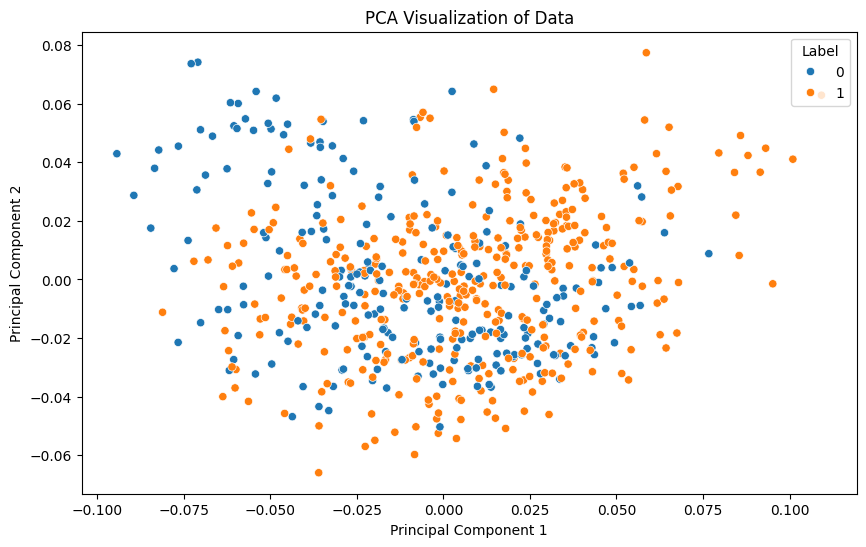

In [33]:
# Plot the data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Label', data=pca_df)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label', loc='upper right')
plt.show()

In [34]:
#for pca I also want to see the explained variance ratio
print(pca.explained_variance_ratio_)

[0.24497141 0.13047555]


### t-SNE Visualisation

In [35]:
#now t-sne visualization
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(df)

# Create DataFrame for visualization
tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE_1', 'TSNE_2'])

#add df_label to that
tsne_df['Label'] = df_labels.values.flatten()

tsne_df.sample(5)


,TSNE_1,TSNE_2,Label
581,-11.157759,14.765167,1
151,8.894436,18.443842,0
533,-5.569560,27.861082,1
109,-3.320325,11.700111,1
567,-10.256123,5.709983,1


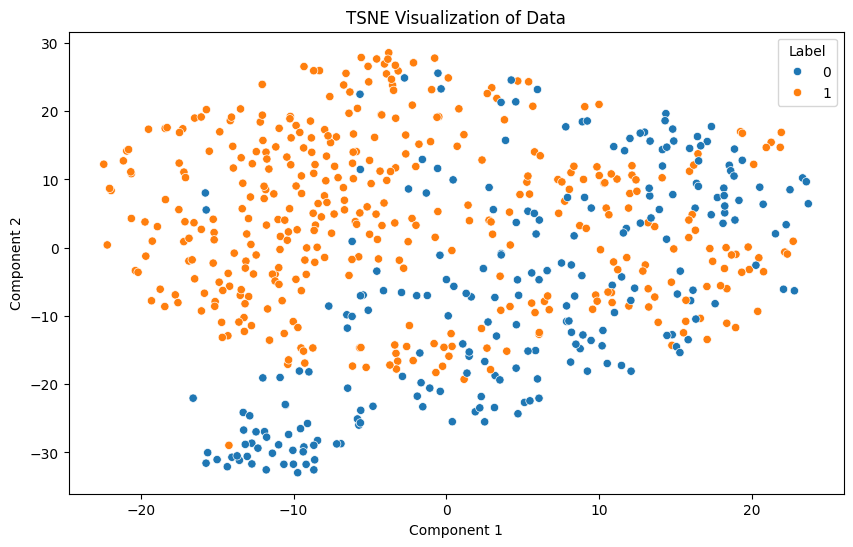

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Label', data=tsne_df)
plt.title('TSNE Visualization of Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Label', loc='upper right')
plt.show()

## Computer Vision filters

### Histogram of Oriented Gradients

In [37]:


index_0=random.randint(0,len(images_0))


image = images_0[index_0]


# Calculate HOG features
features, hog_image = hog(image, orientations=10, pixels_per_cell=(4, 4),
                          cells_per_block=(1, 1), visualize=True)
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 50))



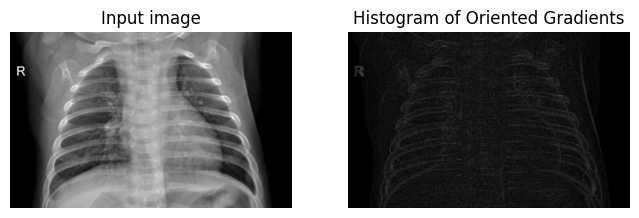

In [38]:
# Plot original and HOG image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### Local Binary Patterns

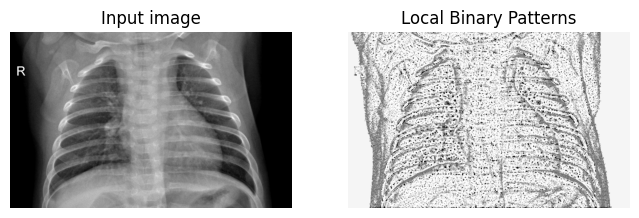

In [39]:
from skimage import feature
import numpy as np

# Set the number of points and radius for LBP
points = 24
radius = 8

# Compute LBP features
lbp = feature.local_binary_pattern(image, points, radius, method="uniform")

# Normalize the histogram
(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
hist = hist.astype("float")
hist /= (hist.sum() + 1e-7)

# Plot the original image and LBP
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(lbp, cmap=plt.cm.gray)
ax2.set_title('Local Binary Patterns')
plt.show()

In [40]:
# %pip install opencv-python

### Color histogram
(not really helpful)

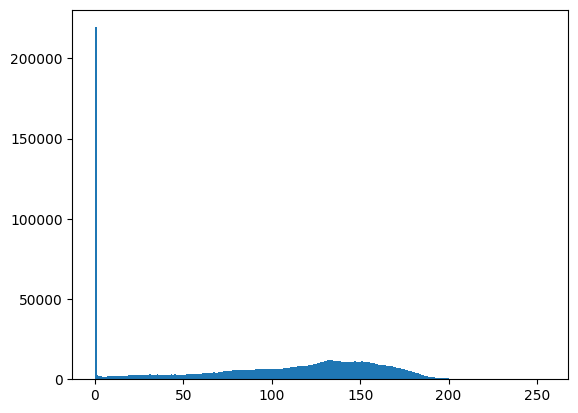

In [41]:
plt.hist(image.ravel(), bins=256)
plt.show()

### Thresholding

#### OTSU thresholding 

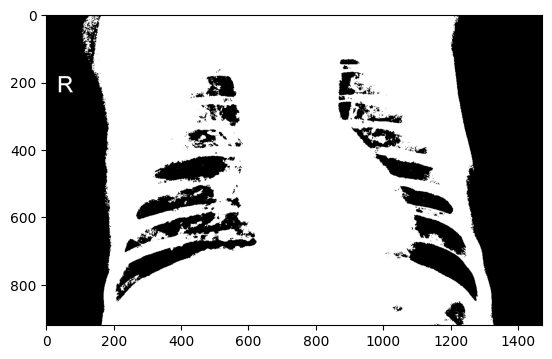

In [73]:
from skimage.filters import threshold_otsu


thresh = threshold_otsu(image)

binary = image > thresh

plt.imshow(binary, cmap='gray')

#### Contours detecting

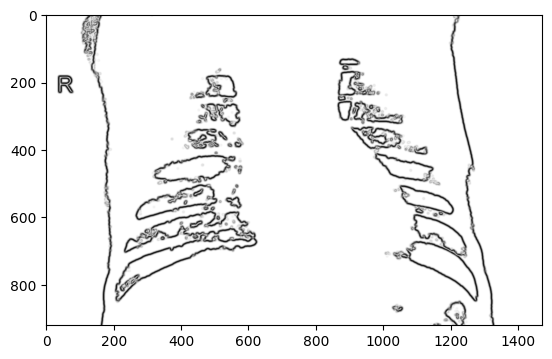

In [75]:
#sisnce eveyrhing is 0/1 i want everything to be white + original contours as a black line
# plt.imshow(binary, cmap='gray')
#rortate upside down binary



# plt.contour(np.flipud(binary), colors='black', linewidths=1)
# plt.axis('off')
from skimage.filters import sobel
from skimage.filters import gaussian

# gaussian_image = image
# gaussian_image = gaussian(binary, sigma=2)


edge_sobel = sobel(binary)
edge_sobel = 1 - edge_sobel

plt.imshow(edge_sobel, cmap='gray')
# plt.imshow(gaussian_image, cmap='gray') 


#idea - prepare PCA and TSNE on countours??

#### Local thresholding

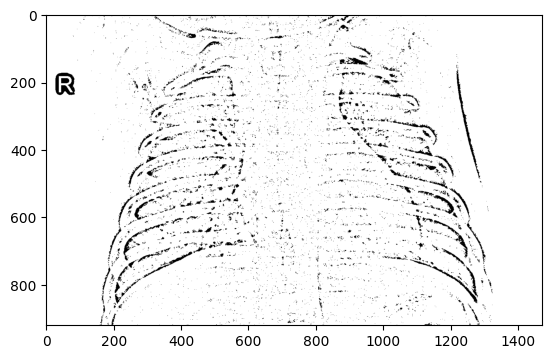

In [56]:
from skimage.filters import threshold_local

block_size=35

local_thresh = threshold_local(image, block_size, offset=10)

binary_local = image > local_thresh

plt.imshow(binary_local, cmap='gray')

#### Try all thresholds


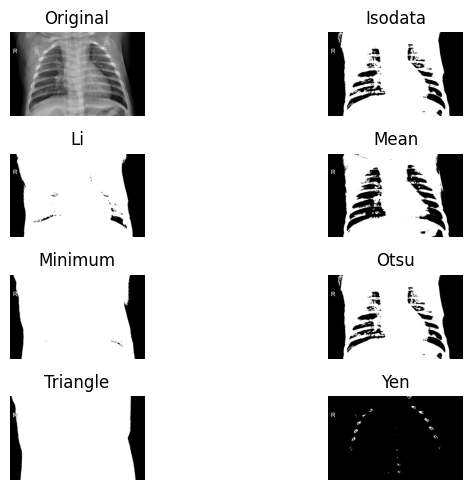

In [58]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(image,  verbose=False)

plt.show()